# Análise de Vendas do E-commerce Olist

Projeto de análise exploratória de dados (EDA) para investigar performance de vendas, eficiência logística e tendências de consumo na plataforma Olist.

In [49]:
import pandas as pd
import kagglehub
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Configuração global para gráficos
%matplotlib inline

# Download automático do dataset (garante que os dados estejam sempre disponíveis)
print("Verificando dataset local...")
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print(f"Diretório dos dados: {path}")

# Mapeamento dos arquivos necessários para a análise
caminho_pedidos = os.path.join(path, "olist_orders_dataset.csv")
caminho_clientes = os.path.join(path, "olist_customers_dataset.csv")
caminho_pagamentos = os.path.join(path, "olist_order_payments_dataset.csv")
caminho_itens = os.path.join(path, "olist_order_items_dataset.csv")
caminho_produtos = os.path.join(path, "olist_products_dataset.csv")

# Carregamento das tabelas dimensionais e fatos
try:
    df_pedidos = pd.read_csv(caminho_pedidos)
    df_clientes = pd.read_csv(caminho_clientes)
    df_pagamentos = pd.read_csv(caminho_pagamentos)
    df_itens = pd.read_csv(caminho_itens)
    df_produtos = pd.read_csv(caminho_produtos)
    print("\nSucesso: Todas as bases foram carregadas.")
except Exception as e:
    print(f"Erro crítico no carregamento: {e}")

Verificando dataset local...
Diretório dos dados: C:\Users\pablo\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2

Sucesso: Todas as bases foram carregadas.


## 1. Análise Financeira e Regional
Consolidação das bases de pedidos, clientes e pagamentos para identificar concentração de receita por estado.

In [50]:
# Unificação das tabelas: Pedidos + Clientes (Localização) + Pagamentos (Receita)
df_principal = pd.merge(df_pedidos, df_clientes, on='customer_id')
df_completo = pd.merge(df_principal, df_pagamentos, on='order_id')

# Padronização dos nomes de colunas para facilitar a manipulação
df_completo = df_completo.rename(columns={
    'order_id': 'id_pedido',
    'customer_id': 'id_cliente', 
    'order_status': 'status_pedido',
    'order_purchase_timestamp': 'data_compra',
    'order_approved_at': 'data_aprovacao',
    'order_delivered_carrier_date': 'data_envio',
    'order_delivered_customer_date': 'data_entrega',
    'order_estimated_delivery_date': 'data_estimada_entrega',
    'customer_city': 'cidade_cliente',
    'customer_state': 'estado_cliente',
    'payment_type': 'tipo_pagamento', 
    'payment_value': 'valor_pagamento'
})

# Conversão de tipos: Transformando strings em objetos de data reais para cálculos temporais
colunas_data = ['data_compra', 'data_aprovacao', 'data_envio', 'data_entrega', 'data_estimada_entrega']
for col in colunas_data:
    df_completo[col] = pd.to_datetime(df_completo[col], errors='coerce')

# Validação da estrutura final
print(f"Tabela Mestra pronta: {df_completo.shape[0]} registros processados.")

Tabela Mestra pronta: 103886 registros processados.


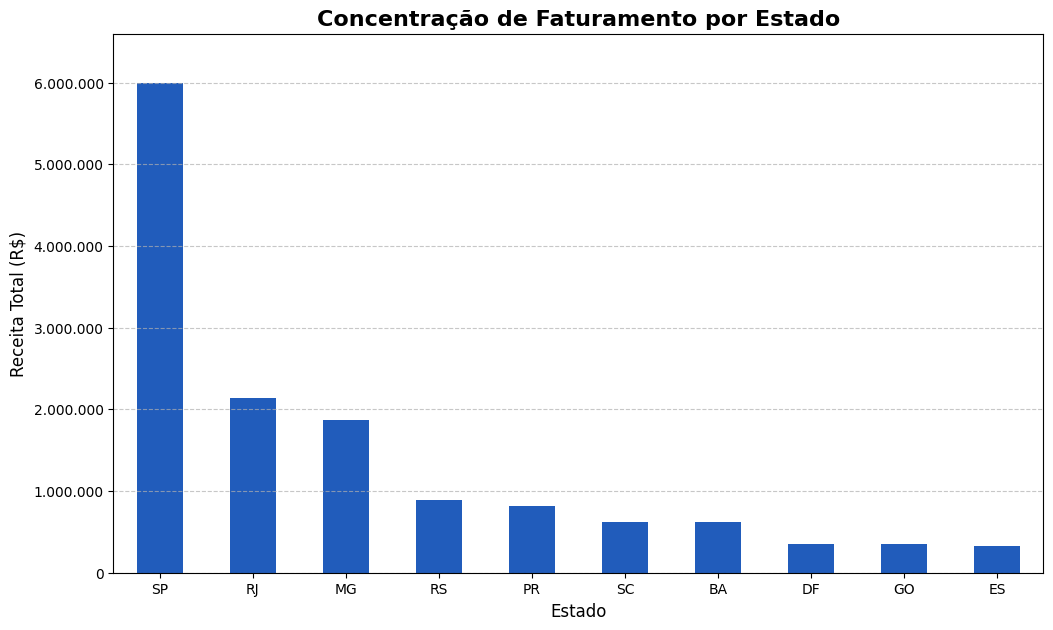

In [51]:
# Agrupamento da receita total por estado
faturamento_por_estado = df_completo.groupby('estado_cliente')['valor_pagamento'].sum().sort_values(ascending=False)

# Visualização: Gráfico de Barras Vertical
plt.figure(figsize=(12, 7))
faturamento_por_estado.head(10).plot(kind='bar', color="#215CBB")

plt.title("Concentração de Faturamento por Estado", fontsize=16, weight='bold')
plt.xlabel("Estado", fontsize=12)
plt.ylabel("Receita Total (R$)", fontsize=12)

# Formatação profissional do eixo Y (Milhares com ponto)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", ".")))

# Ajustes de layout
plt.ylim(0, faturamento_por_estado.max() * 1.1) # Margem superior de 10%
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## 2. Análise Logística: Eficiência e Prazos
Investigação do tempo real de entrega (`Lead Time`) versus a promessa feita ao cliente, identificando padrões regionais.

In [52]:
# Feature Engineering: Cálculo de prazos reais e desvios
# 'dias_entrega_real': Tempo decorrido da compra até a entrega efetiva
df_completo['dias_entrega_real'] = (df_completo['data_entrega'] - df_completo['data_compra']).dt.days

# 'dias_atraso': Diferença entre entrega real e estimada (Negativo = Entrega Antecipada)
df_completo['dias_atraso'] = (df_completo['data_entrega'] - df_completo['data_estimada_entrega']).dt.days

# Criação do painel logístico por estado
logistica_por_estado = df_completo.groupby('estado_cliente').agg(
    Media_Dias_Entrega=('dias_entrega_real', 'mean'),
    Media_Dias_Atraso=('dias_atraso', 'mean')
)

print("Resumo logístico gerado.")

Resumo logístico gerado.


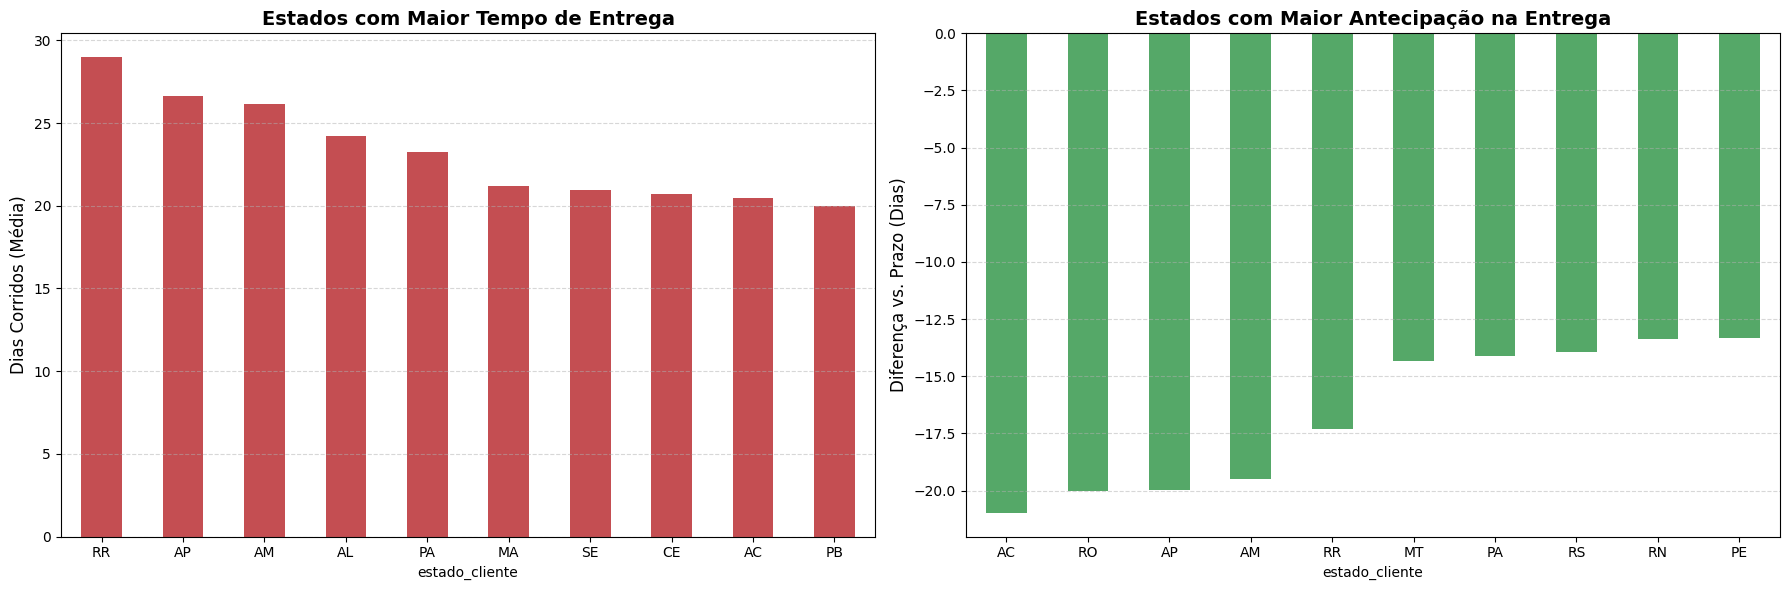

In [53]:
# Configuração de painel duplo (1 linha, 2 colunas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Onde a entrega demora mais? (Gargalos logísticos)
top_10_demorados = logistica_por_estado.sort_values(by='Media_Dias_Entrega', ascending=False).head(10)
top_10_demorados['Media_Dias_Entrega'].plot(kind='bar', ax=ax1, color='#c44e52')

ax1.set_title("Estados com Maior Tempo de Entrega", fontsize=14, weight='bold')
ax1.set_ylabel("Dias Corridos (Média)", fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.tick_params(axis='x', rotation=0)

# Gráfico 2: Onde a entrega chega mais "adiantada"? (Gestão de Expectativa)
# Ordenamos do mais negativo (mais antecipado) para o menos
top_10_adiantados = logistica_por_estado.sort_values(by='Media_Dias_Atraso', ascending=True).head(10)
top_10_adiantados['Media_Dias_Atraso'].plot(kind='bar', ax=ax2, color='#55a868')

ax2.set_title("Estados com Maior Antecipação na Entrega", fontsize=14, weight='bold')
ax2.set_ylabel("Diferença vs. Prazo (Dias)", fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 3. Análise de Produtos: Volume vs. Valor
Teste de hipótese: Categorias de alto valor agregado (ex: eletrônicos) geram mais receita que categorias de alto volume (ex: casa)?

In [54]:
# Enriquecimento dos dados: Unindo itens do pedido com o catálogo de produtos
df_produtos_completo = pd.merge(df_itens, df_produtos, on='product_id')

df_produtos_completo = df_produtos_completo.rename(columns={
    'order_id': 'id_pedido', 
    'product_category_name': 'categoria',
    'price': 'valor_item'
})

# Cálculo das métricas de Volume (Qtd) e Valor (R$)
# Agrupamos por categoria para ver os campeões em cada métrica
top_volume = df_produtos_completo.groupby('categoria')['id_pedido'].count().sort_values(ascending=False)
top_faturamento = df_produtos_completo.groupby('categoria')['valor_item'].sum().sort_values(ascending=False)

print("Rankings de categoria gerados.")

Rankings de categoria gerados.


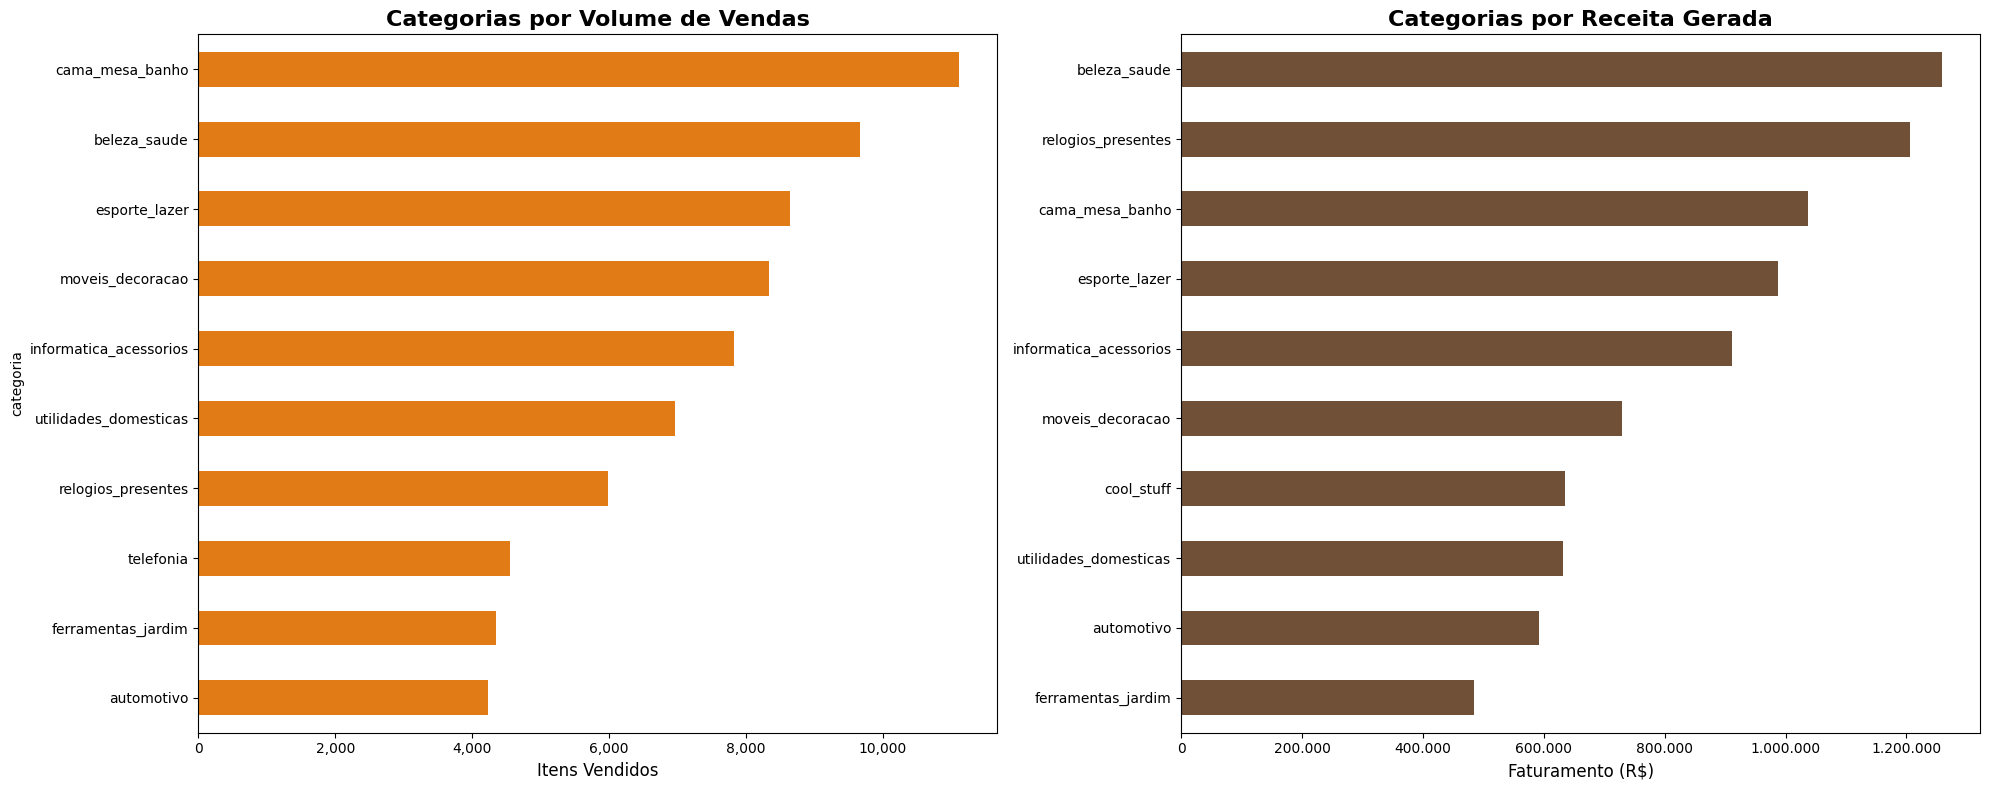

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Gráfico 1: Volume de Vendas
# Invertemos a ordem (.iloc[::-1]) para o campeão ficar no topo do gráfico horizontal
top_volume.head(10).iloc[::-1].plot(kind='barh', ax=ax1, color="#e07b16")
ax1.set_title("Categorias por Volume de Vendas", fontsize=16, weight='bold')
ax1.set_xlabel("Itens Vendidos", fontsize=12)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}")) # Formata milhar

# Gráfico 2: Faturamento Total
top_faturamento.head(10).iloc[::-1].plot(kind='barh', ax=ax2, color="#705037")
ax2.set_title("Categorias por Receita Gerada", fontsize=16, weight='bold')
ax2.set_xlabel("Faturamento (R$)", fontsize=12)
ax2.set_ylabel("") # Remove label redundante
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", ".")))

plt.tight_layout()
plt.show()

## 4. Meios de Pagamento
Análise da preferência do consumidor no momento do checkout.

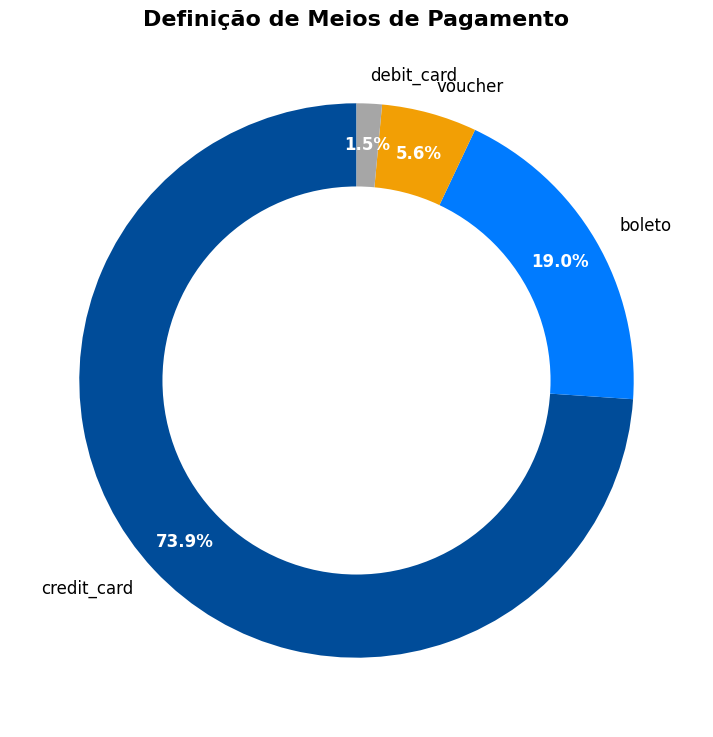

In [56]:
# Contagem de transações por tipo de pagamento
pagamentos = df_completo['tipo_pagamento'].value_counts()

# Filtragem: Removemos 'not_defined' (ruído) para limpar o gráfico
pagamentos = pagamentos[pagamentos.index != 'not_defined']

# Configuração do Gráfico de Donut
plt.figure(figsize=(9, 9))
cores_personalizada = ["#004c99", "#007BFF", "#F29F05", "#A6A6A6", "#5091BF"]

# Plota a pizza
wedges, texts, autotexts = plt.pie(
    pagamentos,
    labels=pagamentos.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=cores_personalizada,
    pctdistance=0.85, # Joga a % para a borda
    textprops={'fontsize': 12}
)

# Estilização das porcentagens (Branco para contraste no azul, ou escuro para pastel)
for text in autotexts:
    text.set_color('white')
    text.set_weight('bold')

# Cria o círculo central para transformar pizza em donut
centro = plt.Circle((0, 0), 0.70, fc='white')
plt.gca().add_artist(centro)

plt.title("Definição de Meios de Pagamento", fontsize=16, weight='bold')
plt.show()

## 5. Conclusões Estratégicas

A análise dos dados revelou padrões claros sobre a operação da Olist:

1.  **Dominância Regional:** O estado de **São Paulo** é o motor da plataforma, gerando quase **R$ 6 milhões** em receita (mais que o dobro do RJ).
2.  **Categoria "Powerhouse":** Contrariando a expectativa de que eletrônicos liderariam a receita, a categoria **Cama, Mesa e Banho** provou ser a mais importante, liderando tanto em volume quanto em valor financeiro.
3.  **Gestão de Expectativa:** A Olist utiliza prazos de entrega estendidos para regiões mais distantes (Norte/Nordeste). Isso resulta em entregas que parecem "super antecipadas" (20 dias antes do prazo), mantendo a satisfação do cliente mesmo com tempos de trânsito longos.
4.  **Crédito é Rei:** O cartão de crédito domina o checkout com **74%** das transações, indicando a importância de manter as taxas de parcelamento competitivas.